In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Load the data
data = pd.read_csv('Data.csv')

# Ensure the date column is in datetime format
data['date'] = pd.to_datetime(data['date'])
data

,date,premise_code,price,premise_type,state
0,2022-01-01,3,6.65,Pasar Raya / Supermarket,Melaka
1,2022-01-03,3,6.65,Pasar Raya / Supermarket,Melaka
2,2022-01-10,3,6.65,Pasar Raya / Supermarket,Melaka
3,2022-02-14,3,6.65,Pasar Raya / Supermarket,Melaka
4,2022-02-21,3,6.65,Pasar Raya / Supermarket,Melaka
...,...,...,...,...,...
183650,2023-12-04,20903,6.90,Pasar Raya / Supermarket,Selangor
183651,2023-12-05,20903,6.90,Pasar Raya / Supermarket,Selangor
183652,2023-12-06,20903,6.90,Pasar Raya / Supermarket,Selangor
183653,2023-12-07,20903,6.90,Pasar Raya / Supermarket,Selangor


In [3]:
# Filter for Selangor state
Selangor_data = data[data['state'] == 'Selangor']
Selangor_data

,date,premise_code,price,premise_type,state
1818,2022-01-01,183,6.7,Pasar Raya / Supermarket,Selangor
1819,2022-01-03,183,6.7,Pasar Raya / Supermarket,Selangor
1820,2022-01-10,183,6.7,Pasar Raya / Supermarket,Selangor
1821,2022-01-11,183,6.7,Pasar Raya / Supermarket,Selangor
1822,2022-01-17,183,6.7,Pasar Raya / Supermarket,Selangor
...,...,...,...,...,...
183650,2023-12-04,20903,6.9,Pasar Raya / Supermarket,Selangor
183651,2023-12-05,20903,6.9,Pasar Raya / Supermarket,Selangor
183652,2023-12-06,20903,6.9,Pasar Raya / Supermarket,Selangor
183653,2023-12-07,20903,6.9,Pasar Raya / Supermarket,Selangor


In [4]:
# Aggregate the data: average price per day
aggregated_data = Selangor_data.groupby('date')['price'].mean().reset_index()
aggregated_data = aggregated_data.sort_values('date')

# Set date as index
aggregated_data.set_index('date', inplace=True)

# Generate a full date range
full_date_range = pd.date_range(start=aggregated_data.index.min(), end=aggregated_data.index.max(), freq='D')

# Reindex the data to this full date range
aggregated_data = aggregated_data.reindex(full_date_range)

# Check for missing values before filling
print("Missing values before filling:")
print(aggregated_data.isnull().sum())

# Fill missing prices
aggregated_data['price'] = aggregated_data['price'].ffill().bfill()

# Reset index to have date as a column again
aggregated_data.reset_index(inplace=True)
aggregated_data.rename(columns={'index': 'date'}, inplace=True)

# Ensure there are no missing values
assert aggregated_data.isnull().sum().sum() == 0

# Check for missing values after filling
print("Missing values after filling:")
print(aggregated_data.isnull().sum())

aggregated_data

Missing values before filling:
price    228
dtype: int64
Missing values after filling:
date     0
price    0
dtype: int64


,date,price
0,2022-01-01,6.826829
1,2022-01-02,6.826829
2,2022-01-03,6.680303
3,2022-01-04,6.680303
4,2022-01-05,6.680303
...,...,...
725,2023-12-27,6.888333
726,2023-12-28,6.888710
727,2023-12-29,6.887500
728,2023-12-30,6.887500


In [5]:
# Handle outliers by capping values at the 1st and 99th percentiles
lower_bound = aggregated_data['price'].quantile(0.01)
upper_bound = aggregated_data['price'].quantile(0.99)
aggregated_data['price'] = np.clip(aggregated_data['price'], lower_bound, upper_bound)


In [6]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
aggregated_data['price'] = scaler.fit_transform(aggregated_data['price'].values.reshape(-1, 1))

# Convert the data to a supervised learning problem
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [7]:
# Define the time step
time_step = 30

# Create the dataset
X, Y = create_dataset(aggregated_data['price'].values.reshape(-1, 1), time_step)


In [8]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [9]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [10]:
# Train the model
model.fit(X_train, Y_train, batch_size=1, epochs=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform([Y_train])
Y_test = scaler.inverse_transform([Y_test])


5/5 [==============================] - 0s 25ms/step


In [11]:
# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate error metrics for the training data
train_mae = mean_absolute_error(Y_train[0], train_predict[:, 0])
train_rmse = np.sqrt(mean_squared_error(Y_train[0], train_predict[:, 0]))
train_mape = mean_absolute_percentage_error(Y_train[0], train_predict[:, 0])

# Calculate error metrics for the testing data
test_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])
test_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0])

# Print the error metrics
print(f'Training MAE: {train_mae}')
print(f'Training RMSE: {train_rmse}')
print(f'Training MAPE: {train_mape}%')

print(f'Testing MAE: {test_mae}')
print(f'Testing RMSE: {test_rmse}')
print(f'Testing MAPE: {test_mape}%')

Training MAE: 0.08408623061135179
Training RMSE: 0.1683368365083202
Training MAPE: 1.165319991845871%
Testing MAE: 0.0578062487911797
Testing RMSE: 0.05787917352017454
Testing MAPE: 0.838876790806151%


In [12]:
# Plot the predictions
train_predict_plot = np.empty_like(aggregated_data['price'])
train_predict_plot[:] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step] = train_predict.flatten()

test_predict_plot = np.empty_like(aggregated_data['price'])
test_predict_plot[:] = np.nan

# Ensure the indices and lengths match correctly
test_start_idx = len(train_predict) + time_step
test_end_idx = test_start_idx + len(test_predict)

# Adjust the end index to match the length of test_predict
if test_end_idx > len(aggregated_data):
    test_end_idx = len(aggregated_data)

test_predict_plot[test_start_idx:test_end_idx] = test_predict.flatten()[:(test_end_idx - test_start_idx)]


In [13]:
# Forecasting future values
n_future_days = 30
future_input = aggregated_data['price'].values[-time_step:]
future_input = future_input.reshape((1, time_step, 1))

future_predict = []
for _ in range(n_future_days):
    future_price = model.predict(future_input)
    future_predict.append(future_price[0, 0])
    future_input = np.append(future_input[:, 1:, :], future_price.reshape((1, 1, 1)), axis=1)

future_predict = scaler.inverse_transform(np.array(future_predict).reshape(-1, 1))


1/1 [==============================] - 0s 243ms/step


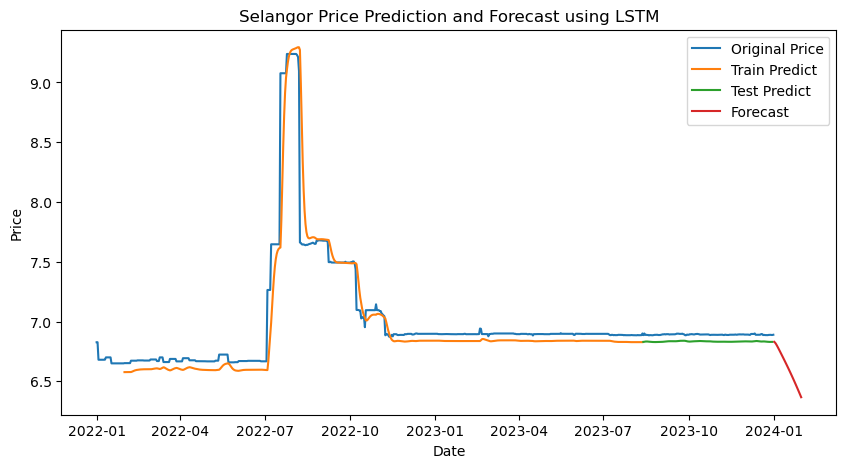

In [14]:
# Create future dates for plotting
future_dates = pd.date_range(start=aggregated_data['date'].iloc[-1] + pd.Timedelta(days=1), periods=n_future_days)

# Combine the original data and the forecast
plt.figure(figsize=(10, 5))
plt.plot(aggregated_data['date'], scaler.inverse_transform(aggregated_data['price'].values.reshape(-1, 1)), label='Original Price')
plt.plot(aggregated_data['date'], train_predict_plot, label='Train Predict')
plt.plot(aggregated_data['date'], test_predict_plot, label='Test Predict')
plt.plot(future_dates, future_predict, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Selangor Price Prediction and Forecast using LSTM')
plt.legend()
plt.show()


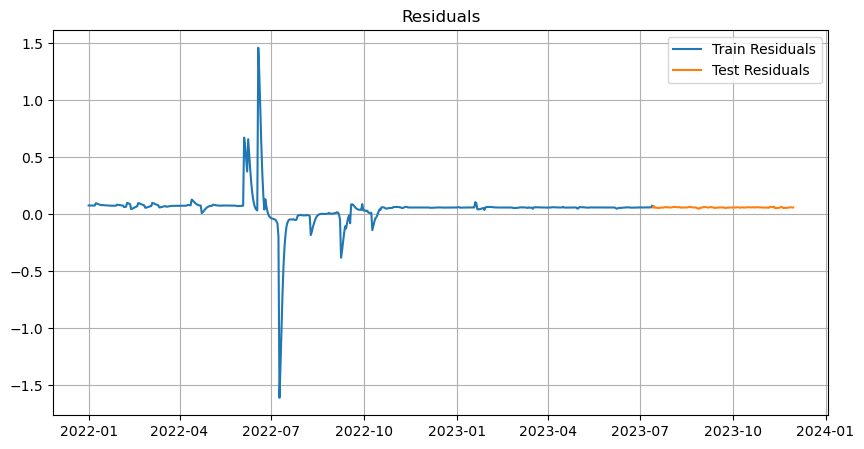

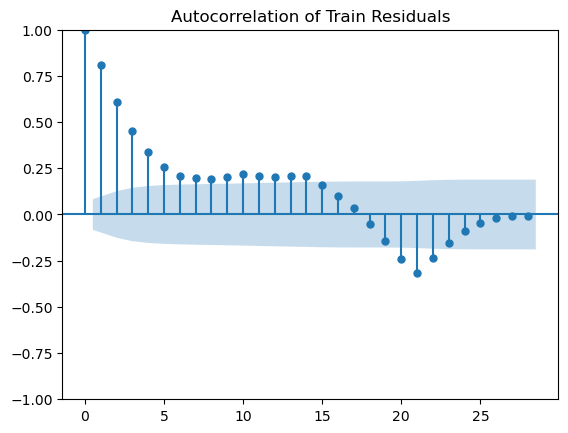

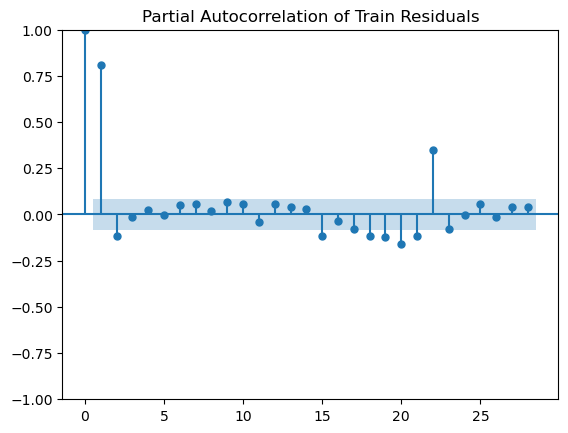

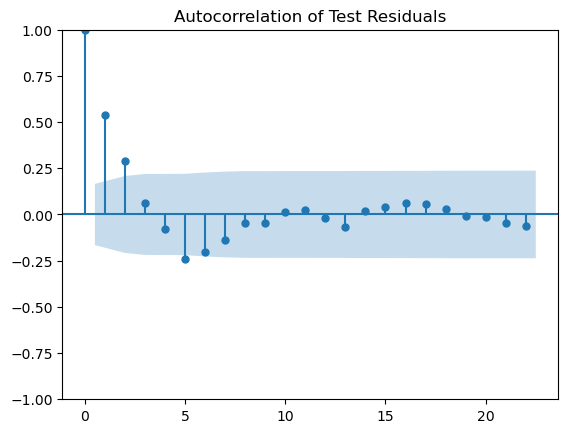

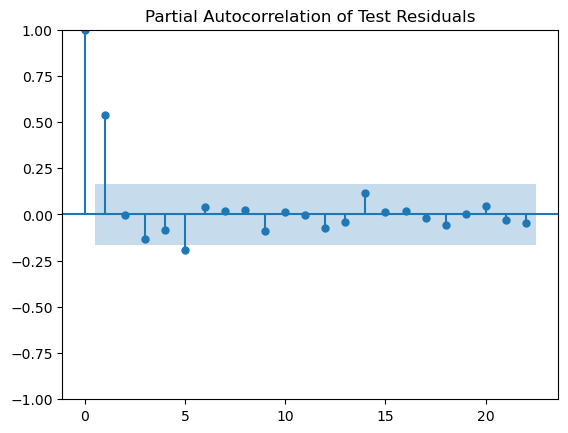

In [15]:
# Compute Residuals
train_residuals = Y_train[0] - train_predict[:, 0]
test_residuals = Y_test[0] - test_predict[:, 0]

# Plot Residuals
plt.figure(figsize=(10, 5))
plt.plot(aggregated_data['date'][:len(train_residuals)], train_residuals, label='Train Residuals')
plt.plot(aggregated_data['date'][len(train_residuals):len(train_residuals) + len(test_residuals)], test_residuals, label='Test Residuals')
plt.title('Residuals')
plt.legend()
plt.grid(True)
plt.show()

# Plot Autocorrelation of Residuals
plot_acf(train_residuals)
plt.title('Autocorrelation of Train Residuals')
plt.show()

plot_pacf(train_residuals)
plt.title('Partial Autocorrelation of Train Residuals')
plt.show()

plot_acf(test_residuals)
plt.title('Autocorrelation of Test Residuals')
plt.show()

plot_pacf(test_residuals)
plt.title('Partial Autocorrelation of Test Residuals')
plt.show()


### TUNING

In [16]:
from keras.callbacks import EarlyStopping

X_train_final shape: (419, 60, 1)
Y_train_final shape: (419,)
X_val shape: (104, 60, 1)
Y_val shape: (104,)
Epoch 1/100
14/14 - 32s - loss: 0.0280 - val_loss: 4.5079e-06 - 32s/epoch - 2s/step
Epoch 2/100
14/14 - 1s - loss: 0.0106 - val_loss: 6.2539e-04 - 1s/epoch - 105ms/step
Epoch 3/100
14/14 - 2s - loss: 0.0083 - val_loss: 5.6761e-05 - 2s/epoch - 128ms/step
Epoch 4/100
14/14 - 2s - loss: 0.0060 - val_loss: 2.2828e-04 - 2s/epoch - 136ms/step
Epoch 5/100
14/14 - 2s - loss: 0.0054 - val_loss: 8.9665e-05 - 2s/epoch - 137ms/step
Epoch 6/100
14/14 - 2s - loss: 0.0048 - val_loss: 5.0487e-06 - 2s/epoch - 136ms/step


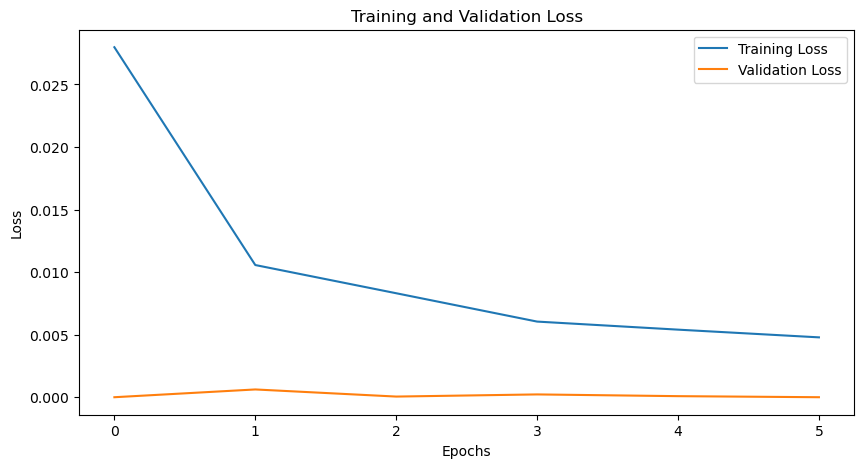

3/3 [==============================] - 0s 32ms/step


In [17]:
# Create and train LSTM model function
def create_and_train_model(X_train, Y_train, X_val, Y_val, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Use EarlyStopping to stop training when validation loss stops improving
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                        epochs=epochs, batch_size=batch_size,
                        callbacks=[early_stopping], verbose=2)

    return model, history

# Data preparation (assuming aggregated_data is already loaded and preprocessed)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(aggregated_data['price'].values.reshape(-1, 1))

time_step = 60

# Function to create dataset
def create_dataset(data, time_step):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Split data into train and test sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Split training data into training and validation sets
val_size = int(len(X_train) * 0.2)
X_train_final, X_val = X_train[:-val_size], X_train[-val_size:]
Y_train_final, Y_val = Y_train[:-val_size], Y_train[-val_size:]

# Ensure the sizes are correct
print(f"X_train_final shape: {X_train_final.shape}")
print(f"Y_train_final shape: {Y_train_final.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Y_val shape: {Y_val.shape}")

# Train the model with more epochs and early stopping
model, history = create_and_train_model(X_train_final, Y_train_final, X_val, Y_val, epochs=100, batch_size=32)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform([Y_train])
Y_test = scaler.inverse_transform([Y_test])

In [18]:
# Calculate error metrics for the training data
train_mae = mean_absolute_error(Y_train[0], train_predict[:, 0])
train_rmse = np.sqrt(mean_squared_error(Y_train[0], train_predict[:, 0]))
train_mape = mean_absolute_percentage_error(Y_train[0], train_predict[:, 0])

# Calculate error metrics for the testing data
test_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])
test_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0])

# Print the error metrics
print(f'Training MAE: {train_mae}')
print(f'Training RMSE: {train_rmse}')
print(f'Training MAPE: {train_mape}%')

print(f'Testing MAE: {test_mae}')
print(f'Testing RMSE: {test_rmse}')
print(f'Testing MAPE: {test_mape}%')


Training MAE: 0.0382710191060391
Training RMSE: 0.09710503391774593
Training MAPE: 78.05990072438594%
Testing MAE: 0.001615438617495676
Testing RMSE: 0.0018838666136733876
Testing MAPE: 1.7282413099872884%


1/1 [==============================] - 0s 111ms/step


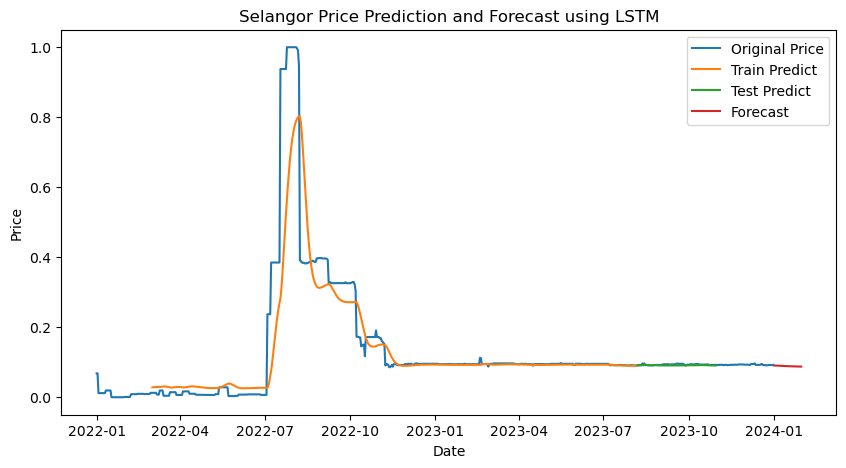

In [19]:
# Ensure train_predict and test_predict are flattened
train_predict_flat = train_predict.flatten()
test_predict_flat = test_predict.flatten()

# Initialize prediction arrays
train_predict_plot = np.empty_like(scaled_data[:, 0])
train_predict_plot[:] = np.nan
test_predict_plot = np.empty_like(scaled_data[:, 0])
test_predict_plot[:] = np.nan

# Assign the predictions to the correct locations in the arrays
train_predict_plot[time_step:len(train_predict_flat) + time_step] = train_predict_flat
test_start_idx = len(train_predict_flat) + time_step
test_end_idx = test_start_idx + len(test_predict_flat)
test_predict_plot[test_start_idx:test_end_idx] = test_predict_flat

# Inverse transform the predictions and original price to the original scale
train_predict_plot = scaler.inverse_transform(train_predict_plot.reshape(-1, 1)).flatten()
test_predict_plot = scaler.inverse_transform(test_predict_plot.reshape(-1, 1)).flatten()
original_price = scaler.inverse_transform(scaled_data).flatten()

# Forecasting future values
n_future_days = 30
future_input = scaled_data[-time_step:]
future_input = future_input.reshape((1, time_step, 1))

future_predict = []
for _ in range(n_future_days):
    future_price = model.predict(future_input)
    future_predict.append(future_price[0, 0])
    future_input = np.append(future_input[:, 1:, :], future_price.reshape((1, 1, 1)), axis=1)

future_predict = scaler.inverse_transform(np.array(future_predict).reshape(-1, 1))

# Align forecast index with test data index
forecast_dates = pd.date_range(start=aggregated_data['date'].iloc[-1] + pd.Timedelta(days=1), periods=n_future_days, freq='D')

# Plotting the forecast
plt.figure(figsize=(10, 5))
plt.plot(aggregated_data['date'], original_price, label='Original Price')
plt.plot(aggregated_data['date'], train_predict_plot, label='Train Predict')
plt.plot(aggregated_data['date'], test_predict_plot, label='Test Predict')
plt.plot(forecast_dates, future_predict, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Selangor Price Prediction and Forecast using LSTM')
plt.legend()
plt.show()


### CROSS VALIDATION

In [20]:
#Load the data
data = pd.read_csv('Data.csv')
data['date'] = pd.to_datetime(data['date'])
Selangor_data = data[data['state'] == 'Selangor']
aggregated_data = Selangor_data.groupby('date')['price'].mean().reset_index()
aggregated_data = aggregated_data.sort_values('date')

# Set date as index
aggregated_data.set_index('date', inplace=True)

# Generate a full date range
full_date_range = pd.date_range(start=aggregated_data.index.min(), end=aggregated_data.index.max(), freq='D')
aggregated_data = aggregated_data.reindex(full_date_range)

# Fill missing prices
aggregated_data['price'] = aggregated_data['price'].ffill()

# Reset index to have date as a column again
aggregated_data.reset_index(inplace=True)
aggregated_data.rename(columns={'index': 'date'}, inplace=True)

# Ensure there are no missing values
assert aggregated_data.isnull().sum().sum() == 0

# Define the dependent variable
Selangor = aggregated_data['price']


In [21]:
# Function to create and train the LSTM model
def create_and_train_model(X_train, Y_train, X_val, Y_val, epochs=100, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Use EarlyStopping to stop training when validation loss stops improving
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
                        epochs=epochs, batch_size=batch_size,
                        callbacks=[early_stopping], verbose=2)

    return model, history

In [22]:
# Function to perform cross-validation
def rolling_forecast_cv(data, n_splits, time_step, epochs=100, batch_size=32):
    """
    Perform rolling forecast cross-validation on time series data using LSTM.

    Parameters:
    - data: pd.Series, the time series data
    - n_splits: int, the number of splits
    - time_step: int, the time step for the LSTM model

    Returns:
    - A tuple of lists containing MAE, RMSE, and MAPE for each split
    """
    mae_list = []
    rmse_list = []
    mape_list = []

    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(data):
        train, test = data.iloc[train_index], data.iloc[test_index]

        # Scale the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
        test_scaled = scaler.transform(test.values.reshape(-1, 1))

        # Prepare the data for LSTM
        X_train, Y_train = [], []
        for i in range(time_step, len(train_scaled)):
            X_train.append(train_scaled[i-time_step:i, 0])
            Y_train.append(train_scaled[i, 0])
        X_train, Y_train = np.array(X_train), np.array(Y_train)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

        X_test, Y_test = [], []
        for i in range(time_step, len(test_scaled)):
            X_test.append(test_scaled[i-time_step:i, 0])
            Y_test.append(test_scaled[i, 0])
        X_test, Y_test = np.array(X_test), np.array(Y_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        # Train the model
        model, history = create_and_train_model(X_train, Y_train, X_test, Y_test, epochs, batch_size)

        # Make predictions
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)

        # Inverse transform the predictions and true values
        train_predict_inv = scaler.inverse_transform(train_predict)
        Y_train_inv = scaler.inverse_transform(Y_train.reshape(-1, 1))

        test_predict_inv = scaler.inverse_transform(test_predict)
        Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

        # Calculate error metrics
        train_mae = mean_absolute_error(Y_train_inv, train_predict_inv)
        train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_predict_inv))
        train_mape = np.mean(np.abs((Y_train_inv - train_predict_inv) / Y_train_inv)) * 100

        test_mae = mean_absolute_error(Y_test_inv, test_predict_inv)
        test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_predict_inv))
        test_mape = np.mean(np.abs((Y_test_inv - test_predict_inv) / Y_test_inv)) * 100

        # Append the results
        mae_list.append(test_mae)
        rmse_list.append(test_rmse)
        mape_list.append(test_mape)

    return mae_list, rmse_list, mape_list

# Perform cross-validation
n_splits = 5
time_step = 60
mae_list, rmse_list, mape_list = rolling_forecast_cv(Selangor, n_splits, time_step, epochs=100, batch_size=32)

# Print results
print("Cross-Validation Results:")
print("MAE:", mae_list)
print("RMSE:", rmse_list)
print("MAPE:", mape_list)
print("Average MAE:", np.mean(mae_list))
print("Average RMSE:", np.mean(rmse_list))
print("Average MAPE:", np.mean(mape_list))


Epoch 1/100
3/3 - 26s - loss: 0.0302 - val_loss: 75.6501 - 26s/epoch - 9s/step
Epoch 2/100
3/3 - 1s - loss: 0.0063 - val_loss: 66.8955 - 540ms/epoch - 180ms/step
Epoch 3/100
3/3 - 1s - loss: 0.0109 - val_loss: 66.3375 - 618ms/epoch - 206ms/step
Epoch 4/100
3/3 - 1s - loss: 0.0092 - val_loss: 68.0987 - 743ms/epoch - 248ms/step
Epoch 5/100
3/3 - 1s - loss: 0.0046 - val_loss: 70.4758 - 557ms/epoch - 186ms/step
Epoch 6/100
3/3 - 1s - loss: 0.0053 - val_loss: 71.8690 - 535ms/epoch - 178ms/step
Epoch 7/100
3/3 - 1s - loss: 0.0072 - val_loss: 72.3117 - 560ms/epoch - 187ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0073 - val_loss: 72.0928 - 485ms/epoch - 162ms/step
2/2 [==============================] - 0s 31ms/step
Epoch 1/100
6/6 - 19s - loss: 0.0740 - val_loss: 0.0060 - 19s/epoch - 3s/step
Epoch 2/100
6/6 - 1s - loss: 0.0358 - val_loss: 0.0065 - 571ms/epoch - 95ms/step
Epoch 3/100
6/6 - 1s - loss: 0.0260 - val_loss: 6.4499e-04 - 649ms/epoch - 108ms/step
Epoch 4/100
6/6 - 1s - loss: 0.0218 - val_l

### MODEL VALIDATION

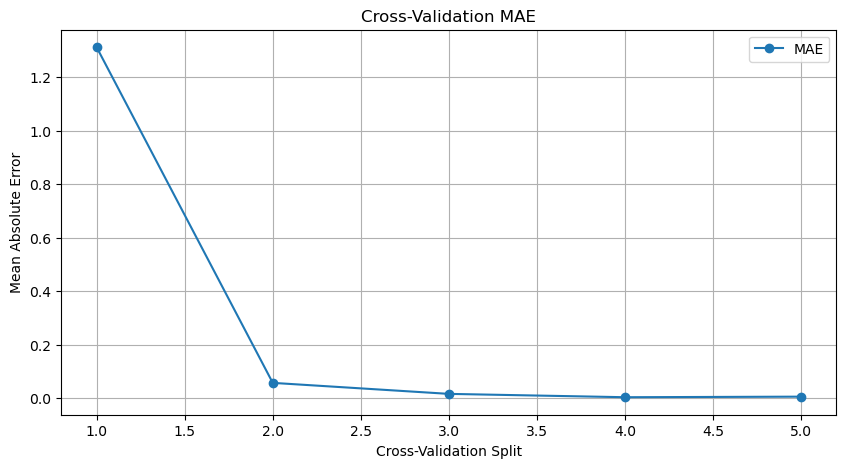

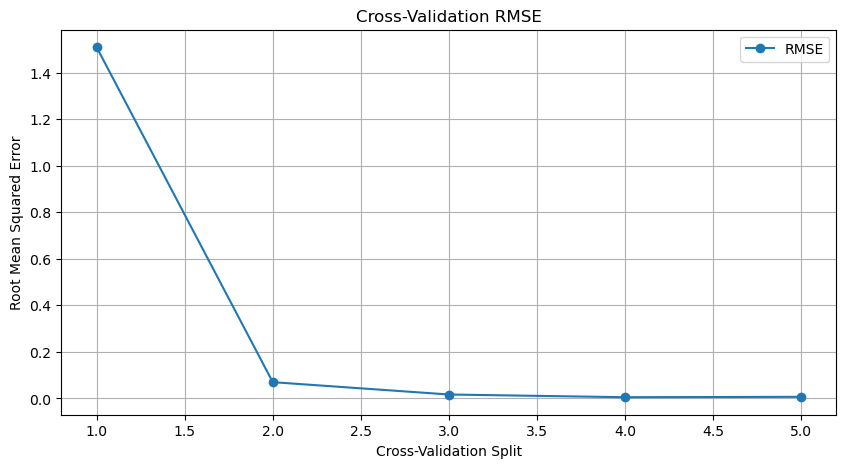

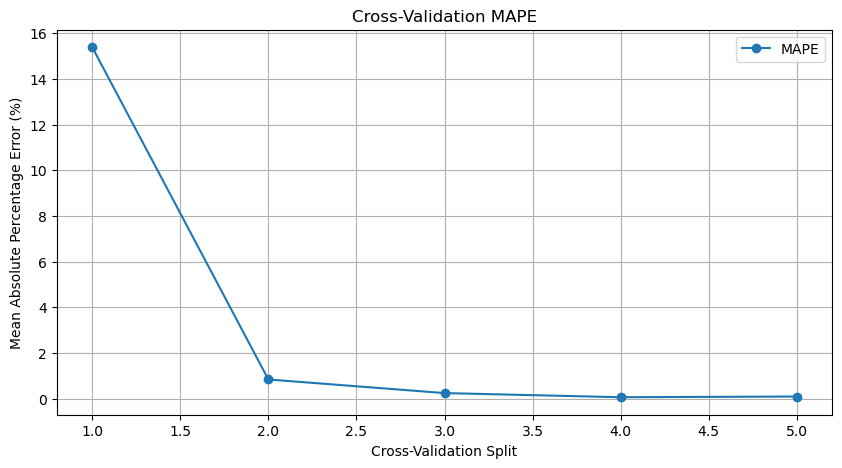

In [23]:
# Plot MAE
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_splits + 1), mae_list, marker='o', label='MAE')
plt.xlabel('Cross-Validation Split')
plt.ylabel('Mean Absolute Error')
plt.title('Cross-Validation MAE')
plt.grid(True)
plt.legend()
plt.show()

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_splits + 1), rmse_list, marker='o', label='RMSE')
plt.xlabel('Cross-Validation Split')
plt.ylabel('Root Mean Squared Error')
plt.title('Cross-Validation RMSE')
plt.grid(True)
plt.legend()
plt.show()

# Plot MAPE
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_splits + 1), mape_list, marker='o', label='MAPE')
plt.xlabel('Cross-Validation Split')
plt.ylabel('Mean Absolute Percentage Error (%)')
plt.title('Cross-Validation MAPE')
plt.grid(True)
plt.legend()
plt.show()


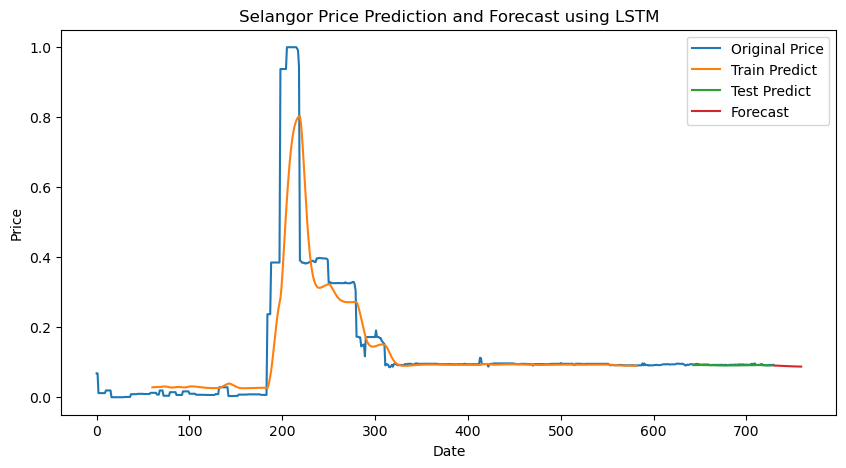

In [24]:
# Plot the predictions
train_predict_plot = np.empty(len(scaled_data))
train_predict_plot[:] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step] = train_predict.flatten()

test_predict_plot = np.empty(len(scaled_data))
test_predict_plot[:] = np.nan
test_start_idx = len(train_predict) + (time_step * 2)
test_end_idx = test_start_idx + len(test_predict)
test_predict_plot[test_start_idx:test_end_idx] = test_predict.flatten()

# Plot the forecast
plt.figure(figsize=(10, 5))
plt.plot(scaler.inverse_transform(scaled_data.reshape(-1, 1)), label='Original Price')
plt.plot(train_predict_plot, label='Train Predict')
plt.plot(test_predict_plot, label='Test Predict')
plt.plot(np.arange(len(scaled_data), len(scaled_data)+n_future_days), future_predict, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Selangor Price Prediction and Forecast using LSTM')
plt.legend()
plt.show()


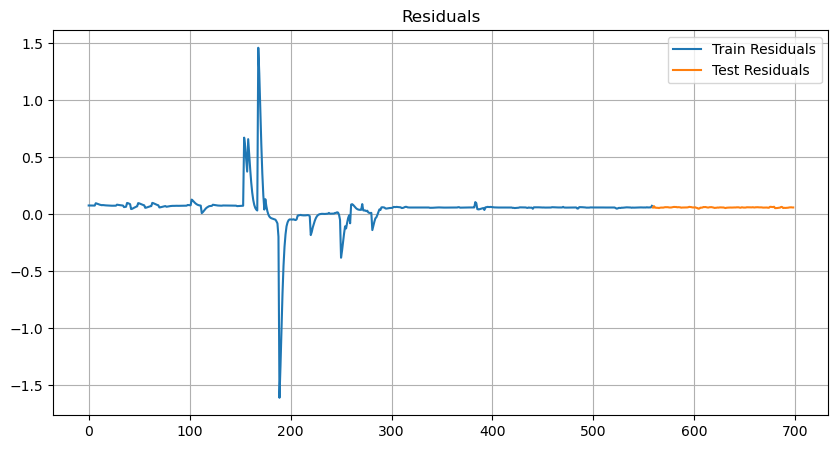

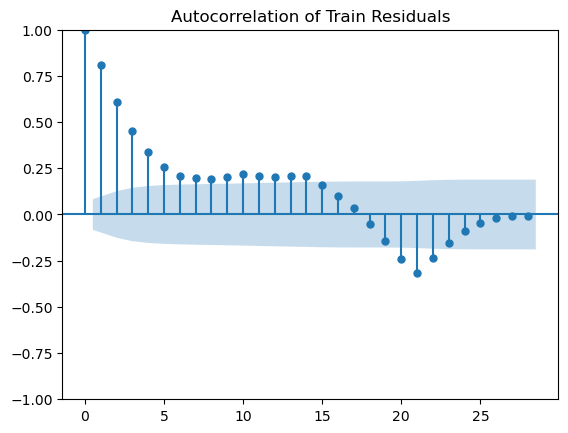

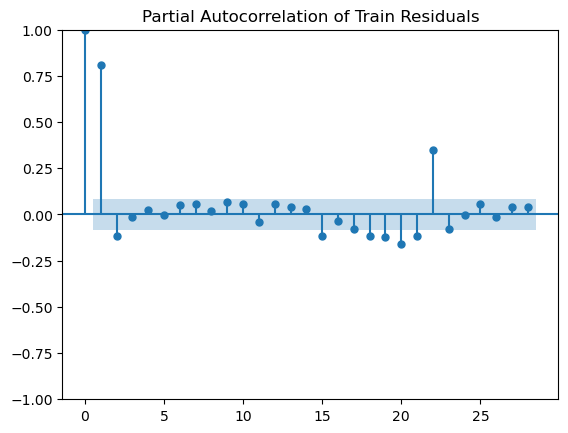

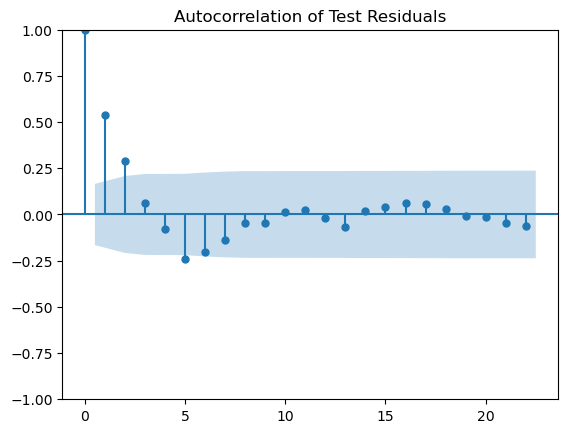

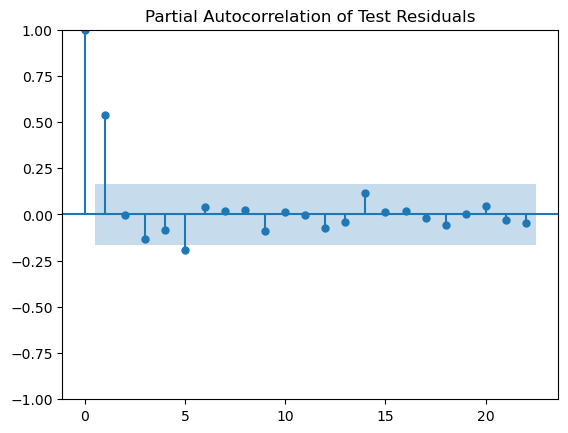

In [25]:
# Plot residuals
plt.figure(figsize=(10, 5))
plt.plot(train_residuals, label='Train Residuals')
plt.plot(np.arange(len(train_residuals), len(train_residuals) + len(test_residuals)), test_residuals, label='Test Residuals')
plt.title('Residuals')
plt.legend()
plt.grid(True)
plt.show()

# Autocorrelation of Train Residuals
plot_acf(train_residuals)
plt.title('Autocorrelation of Train Residuals')
plt.show()
plot_pacf(train_residuals)
plt.title('Partial Autocorrelation of Train Residuals')
plt.show()

# Autocorrelation of Test Residuals
plot_acf(test_residuals)
plt.title('Autocorrelation of Test Residuals')
plt.show()
plot_pacf(test_residuals)
plt.title('Partial Autocorrelation of Test Residuals')
plt.show()


In [26]:
# Combine the original price data and the predictions into a single DataFrame
results = pd.DataFrame({
    'date': aggregated_data['date'],
    'original': scaler.inverse_transform(aggregated_data['price'].values.reshape(-1, 1)).flatten(),
    'train': train_predict_plot,
    'test': test_predict_plot
})

# Append the future predictions to the DataFrame
future_df = pd.DataFrame({
    'date': future_dates,
    'original': np.nan,
    'train': np.nan,
    'test': np.nan,
    'forecast': future_predict.flatten()
})

# Combine both dataframes
results = pd.concat([results, future_df], ignore_index=True)

# Save to CSV
results.to_csv('Selangor.csv', index=False)


In [27]:
import csv

# Save metrics to a CSV file
metrics = {
    'Training MAE': train_mae,
    'Training RMSE': train_rmse,
    'Training MAPE': train_mape,
    'Testing MAE': test_mae,
    'Testing RMSE': test_rmse,
    'Testing MAPE': test_mape
}

with open('Selangor_metrics.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Metric', 'Value'])
    for key, value in metrics.items():
        writer.writerow([key, value])

# Save cross-validation results to a CSV file
cv_results = {
    'MAE': mae_list,
    'RMSE': rmse_list,
    'MAPE': mape_list
}

with open('Selangor_cv_results.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Split', 'MAE', 'RMSE', 'MAPE'])
    for i in range(n_splits):
        writer.writerow([i+1, mae_list[i], rmse_list[i], mape_list[i]])
